# 1. Data Acquisition & Preparation

## a. Downloading the Data:
The latest monthly Citi Bike dataset is available from the Citi Bike System Data S3 bucket (e.g., https://s3.amazonaws.com/tripdata/index.html). Everymonth two new files are added:
1. For Jersey City -> JC-YYYYMM-citibike-tripdata.csv.zip
2. For NYC -> YYYYMM-citibike-tripdata.zip (From 2013 till 2023 files are anually, from 2024 upwards files are monthly)

In case of January 2025 there is three files availble in the zip (_1,_2,_3) sharing same schema

## b. Ingesting the Data with PySpark:
Start a Spark session and read the CSV file into a DataFrame. We can let Spark infer the schema (or provide an explicit schema for better performance).

In [1]:
import os
import glob
import zipfile
import platform

def extract_all_zips(zip_folder, extract_to):
    """
    Extracts all zip files found in the given folder into the specified extraction directory.

    Parameters:
    zip_folder (str): Path to the folder containing zip files.
    extract_to (str): Path to the directory where the CSV files will be extracted.
    """
    # Normalize paths for cross-platform compatibility
    zip_folder = os.path.abspath(zip_folder)
    extract_to = os.path.abspath(extract_to)

    # Ensure the extraction directory exists.
    os.makedirs(extract_to, exist_ok=True)

    # Find all zip files in the specified folder.
    zip_files = glob.glob(os.path.join(zip_folder, "*.zip"))

    # Iterate over each zip file and extract its contents.
    for zip_file in zip_files:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
            print(f"Extracted {zip_file} to {extract_to}")

# --- Usage ---

# Set paths for zip folder and extraction directory
current_dir = os.getcwd()
zip_folder_path = os.path.join(current_dir, "raw_data")  # Update as needed
extract_dir = os.path.join(current_dir, "data")          # Folder to hold extracted CSV files

# Ensure paths are formatted correctly for Spark (Windows needs forward slashes)
if platform.system() == "Windows":
    zip_folder_path = zip_folder_path.replace(os.sep, "/")
    extract_dir = extract_dir.replace(os.sep, "/")

# Extract all CSV files from the zip files.
extract_all_zips(zip_folder_path, extract_dir)



Extracted c:\Git\NYCBS\raw_data\202501-citibike-tripdata.zip to c:\Git\NYCBS\data


In [ ]:
import os
from pyspark.sql import SparkSession

# Create a basic Spark session
spark = SparkSession.builder \
    .appName("SimpleSpark") \
    .master("local[1]") \
    .getOrCreate()

print("Spark session created")
print("Spark version:", spark.version)
print("Java version:", spark._jvm.System.getProperty("java.version"))

In [2]:
import os
import platform
from pyspark.sql import SparkSession

# Get the current working directory
current_dir = os.getcwd()

# Ensure paths are correctly formatted for both Windows and Mac/Linux
catalog_path = os.path.join(current_dir, "catalog", "iceberg.db")
db_dir = os.path.dirname(catalog_path)
os.makedirs(db_dir, exist_ok=True)

# Handle JDBC URL formatting for different OS
if platform.system() == "Windows":
    jdbc_url = f"jdbc:sqlite:///{catalog_path.replace(os.sep, '/')}"  # Convert \ to /
    warehouse_url = f"file:///{os.path.join(current_dir, 'dwh').replace(os.sep, '/')}"
else:
    jdbc_url = f"jdbc:sqlite:///{catalog_path}"
    warehouse_url = f"file://{os.path.join(current_dir, 'dwh')}"

# Set the directory where CSV files have been extracted
extract_dir = os.path.join(current_dir, "data")
os.makedirs(extract_dir, exist_ok=True)

# Ensure the "dwh" warehouse directory exists
warehouse_dir = os.path.join(current_dir, "dwh")
os.makedirs(warehouse_dir, exist_ok=True)

spark = SparkSession.builder \
    .appName("SparkIcebergExample") \
    .master("local[1]") \
    .config("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions") \
    .config("spark.sql.catalog.local_pc", "org.apache.iceberg.spark.SparkCatalog") \
    .config("spark.sql.catalog.local_pc.type", "hadoop") \
    .config("spark.sql.catalog.local_pc.warehouse", warehouse_url) \
    .getOrCreate()

print("Spark session created")
print("Spark version:", spark.version)
print("Java version:", spark._jvm.System.getProperty("java.version"))

# Print relevant Spark configurations
for key, value in spark.sparkContext.getConf().getAll():
    if "catalog.local" in key:
        print(f"{key}: {value}")

# Read and display the contents of the CSV files
csv_path = os.path.join(extract_dir, "*.csv").replace(os.sep, "/")  # Ensure forward slashes for Spark compatibility
print(f"reading files from {csv_path}")

df = spark.read.csv("c:/Git/NYCBS/data/202501-citibike-tripdata_1.csv", header=True, inferSchema=True)
print("reading file 202501-citibike-tripdata_1.csv")
df1 = spark.read.csv("c:/Git/NYCBS/data/202501-citibike-tripdata_2.csv", header=True, inferSchema=True)
print("reading file 202501-citibike-tripdata_2.csv")
df2 = spark.read.csv("c:/Git/NYCBS/data/202501-citibike-tripdata_3.csv", header=True, inferSchema=True)
print("reading file 202501-citibike-tripdata_3.csv")

#merge the dataframes
df = df.union(df1).union(df2)

df.show()

print(f"Number of rows: {df.count()}")

Spark session created
Spark version: 3.5.5
Java version: 11.0.25
spark.sql.catalog.local_pc.warehouse: file:///c:/Git/NYCBS/dwh
spark.sql.catalog.local_pc: org.apache.iceberg.spark.SparkCatalog
spark.sql.catalog.local_pc.type: hadoop
reading files from c:/Git/NYCBS/data/*.csv
reading file 202501-citibike-tripdata_1.csv
reading file 202501-citibike-tripdata_2.csv
reading file 202501-citibike-tripdata_3.csv
+----------------+-------------+--------------------+--------------------+--------------------+----------------+--------------------+--------------+-----------------+------------------+-----------------+------------------+-------------+
|         ride_id|rideable_type|          started_at|            ended_at|  start_station_name|start_station_id|    end_station_name|end_station_id|        start_lat|         start_lng|          end_lat|           end_lng|member_casual|
+----------------+-------------+--------------------+--------------------+--------------------+----------------+-----

In [3]:
#display the df schema
df.printSchema()

root
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- member_casual: string (nullable = true)



In [4]:
#describe the df
df.describe().show()

+-------+----------------+-------------+--------------------+-----------------+--------------------+-----------------+--------------------+-------------------+-------------------+------------------+-------------+
|summary|         ride_id|rideable_type|  start_station_name| start_station_id|    end_station_name|   end_station_id|           start_lat|          start_lng|            end_lat|           end_lng|member_casual|
+-------+----------------+-------------+--------------------+-----------------+--------------------+-----------------+--------------------+-------------------+-------------------+------------------+-------------+
|  count|         2124475|      2124475|             2123911|          2123911|             2120500|          2120153|             2124475|            2124475|            2124206|           2124206|      2124475|
|   mean|        Infinity|         NULL|                NULL|5924.951078772682|                NULL|5923.929563775581|   40.73695340244103| -73.9715

## c. Data Cleaning:
Perform cleaning tasks such as:
-	Dropping rows with missing critical fields (e.g., start/end timestamps).
-	Converting timestamp strings to proper timestamp types.
-	Filtering out trips with negative or zero durations.

# 2. Analysis & Insights

## A. Insurance Coverage Analysis

Counting Trips Over 30 Minutes:
- Filter the DataFrame for trips where trip_duration > 30 minutes and count them.

In [5]:
from pyspark.sql.functions import col, unix_timestamp, to_date
from pyspark.sql import functions as F

insurance_trip_duration = 30

# Drop rows with missing timestamps
df = df.dropna(subset=["started_at", "ended_at"])

# extract rental_date from started_at
df = df.withColumn("rental_date", to_date(col("started_at")))

# Convert time columns to timestamp and compute trip duration in minutes
df = df.withColumn("start_ts", unix_timestamp("started_at")) \
       .withColumn("end_ts", unix_timestamp("ended_at"))

# Calculate duration (in minutes) and filter out invalid records
df = df.withColumn("trip_duration", (col("end_ts") - col("start_ts")) / 60)
df = df.filter(col("trip_duration") > 0)

#add a column to flag trips that are longer than 30 minutes
df = df.withColumn("insurance_trip", F.when(col("trip_duration") > insurance_trip_duration, 1).otherwise(0))


In [6]:
insurance_trips = df.filter(col("trip_duration") > 30)
num_insurance_trips = insurance_trips.count()
print(f"Trips longer than 30 minutes: {num_insurance_trips}")

Trips longer than 30 minutes: 58708


## B. Revenue Estimation

Estimating Revenue Impact:
- Assume a charge of $0.20 per trip that exceeds 30 minutes. Multiply the count by $0.20.

In [7]:
revenue = num_insurance_trips * 0.20
print(f"Estimated revenue from over-30-min rides: ${revenue:.2f}")

Estimated revenue from over-30-min rides: $11741.60


## C. Travel Distance Analysis

1. Calculating the Distance (Haversine Formula):
- As the dataset includes starting and ending coordinates (e.g., start station latitude, start station longitude, end station latitude, end station longitude), we can compute the great-circle distance using the haversine formula. 
- Here’s an example using Spark SQL functions:

In [8]:
import pyspark.sql.functions as F

# Earth's radius in kilometers
EARTH_RADIUS = 6371.0

# Convert coordinates and calculate haversine 'a' factor
df = df.withColumn("start_lat_rad", F.radians(col("start_lat"))) \
       .withColumn("start_lon_rad", F.radians(col("start_lng"))) \
       .withColumn("end_lat_rad", F.radians(col("end_lat"))) \
       .withColumn("end_lon_rad", F.radians(col("end_lng")))

df = df.withColumn("dlat", col("end_lat_rad") - col("start_lat_rad")) \
       .withColumn("dlon", col("end_lon_rad") - col("start_lon_rad"))

# Compute haversine distance in km
df = df.withColumn("a", F.pow(F.sin(col("dlat")/2), 2) + 
                   F.cos(col("start_lat_rad")) * F.cos(col("end_lat_rad")) * 
                   F.pow(F.sin(col("dlon")/2), 2))
df = df.withColumn("distance_km", 2 * EARTH_RADIUS * F.asin(F.sqrt(col("a"))))

2. Classifying Trips into Distance Buckets:
Create a new column to assign each trip into one of the specified buckets.

In [9]:
df = df.withColumn("distance_bucket",
    F.when(col("distance_km") <= 1, "0-1 km")
     .when((col("distance_km") > 1) & (col("distance_km") <= 4), "2-4 km")
     .when((col("distance_km") > 4) & (col("distance_km") <= 9), "4-9 km")
     .otherwise("10+ km")
)

3. Visualization:
Convert the aggregated data (e.g., count per distance bucket) to Pandas and use matplotlib or seaborn to plot the distribution.

C:\Users\aldam\AppData\Local\Temp\ipykernel_24964\485367000.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


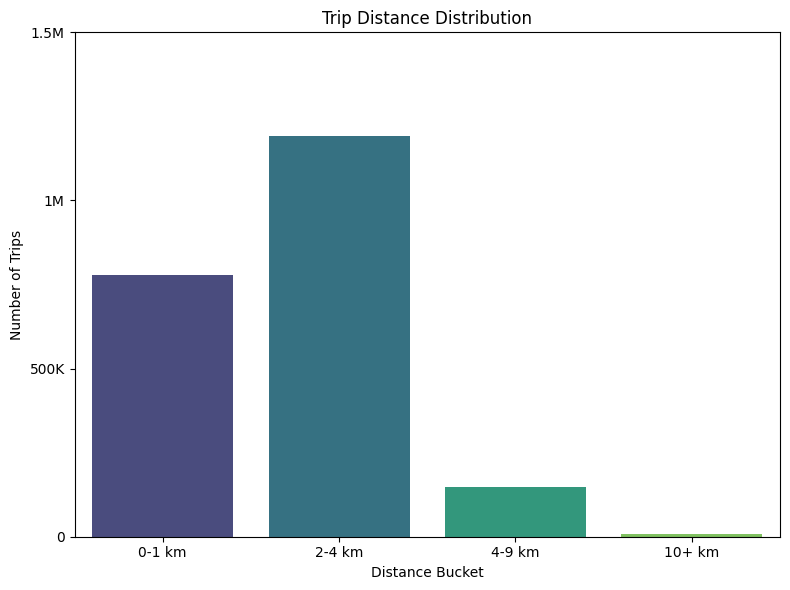

In [10]:
# Aggregate counts by bucket and convert to Pandas DataFrame
bucket_distribution = df.groupBy("distance_bucket").count().toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
ax = sns.barplot(
    x="distance_bucket",
    y="count",
    data=bucket_distribution,
    palette="viridis",
    order=["0-1 km", "2-4 km", "4-9 km", "10+ km"]  # Specify your custom order here
    )
ax.set_title("Trip Distance Distribution")
ax.set_xlabel("Distance Bucket")
ax.set_ylabel("Number of Trips")

# Example: set y-ticks at 0, 500k, 1M, 1.5M, etc.
ax.set_yticks([0, 500_000, 1_000_000, 1_500_000])
ax.set_yticklabels(["0", "500K", "1M", "1.5M"])

plt.tight_layout()
plt.show()